In [ ]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
#         print(os.path.join(dirname, filename))
        pass

### Dataset Name: brain-tumor-mri-dataset

Categories: The dataset is organized into four categories, each representing a different class:

Glioma,Meningioma,Notumor and Pituitary


In [ ]:
train_loc = '/kaggle/input/Training'
test_loc =  '/kaggle/input/Testing'

In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

### Data Transformation and Loading

We apply transformations to convert images to grayscale, resize them to 28x28 pixels, and normalize their pixel values to the range [-1, 1]. These transformations are used to load the training and test datasets from specified directories using `datasets.ImageFolder`.


In [ ]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Ensures single channel for grayscale
    transforms.Resize((28, 28)),  # Resize to match the model's expected input
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [ ]:
train_dataset = datasets.ImageFolder(
    root=train_loc,                       # Path to your train dataset
    transform=transform                    # Apply transformations
)

test_dataset = datasets.ImageFolder(
    root=test_loc,                        # Path to your test dataset
    transform=transform                    # Apply transformations
)

### DataLoader Setup

We create data loaders for both training and testing datasets with a batch size of 32. The training data is shuffled for better generalization, while the test data remains in order. The `num_workers` parameter is set to 4 to speed up data loading.


In [ ]:
train_loader = DataLoader(
    train_dataset,
    batch_size=32,               # Set batch size
    shuffle=True,                # Shuffle dataset during training
    num_workers=4                # Number of workers for data loading (adjust based on your machine)
)

test_loader = DataLoader(
    test_dataset,
    batch_size=32,               # Set batch size
    shuffle=False,               # No need to shuffle test set
    num_workers=4                # Number of workers for data loading
)

### Training Function

The `train_model` function handles the training loop for the model. It takes in the model, data loader, loss function, optimizer, and the number of epochs as parameters:

- **Forward Pass**: Computes model predictions.
- **Loss Calculation**: Uses the specified criterion (e.g., CrossEntropy).
- **Backward Pass**: Computes gradients via backpropagation.
- **Optimizer Step**: Updates model parameters to minimize the loss.
- **Training Loop**: Repeats for the specified number of epochs, printing the average loss per epoch.


In [ ]:
# Training function
def train_model(model, train_loader, criterion, optimizer, epochs=1):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {running_loss / len(train_loader):.4f}")

### Evaluation Function

The `evaluate_model` function assesses the model's performance on the test set:

- **Model Evaluation Mode**: Disables dropout and batch normalization layers.
- **No Gradient Calculation**: Speeds up evaluation by preventing gradient computation.
- **Accuracy Calculation**: Compares predicted labels with ground truth to compute the accuracy.
- **Results**: Prints the accuracy of the model on the test dataset.


In [ ]:
# Evaluation function
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
#             print(images, labels)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            print(predicted)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy of the model on the test set: {accuracy:.2f}%')

### Classification Report Function

The `classification_report` function generates a detailed performance report using `sklearn.metrics.classification_report`:

- **Collects Predictions**: Gathers true labels and model predictions from the test set.
- **Evaluation Metrics**: Provides precision, recall, and F1-score for each class.
- **Results**: Prints a comprehensive classification report, helping assess model performance beyond just accuracy.


In [ ]:
def classification_report(model):
    from sklearn.metrics import classification_report

    # Collect true labels and predictions
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    print(classification_report(all_labels, all_preds))

### Evaluation with Visualization

The `evaluate_and_plot` function not only evaluates the model but also visualizes its predictions:

- **Model in Evaluation Mode**: Ensures the model does not update gradients.
- **Image Visualization**: Displays `num_images` test samples, starting from a specified index, along with their predicted and actual labels.
- **Plotting**: Uses `matplotlib` to show grayscale images, making it easier to interpret model predictions visually.


In [ ]:
import matplotlib.pyplot as plt
import torch

# Evaluation function with plotting
def evaluate_and_plot(model, test_loader, num_images=5, start_index=1200):
    model.eval()
    images_shown = 0

    # Iterate through the test_loader, skipping the first `start_index` samples
    with torch.no_grad():
        for idx, (images, labels) in enumerate(test_loader):
            # Skip the first `start_index` batches
            if idx < start_index // test_loader.batch_size:
                continue

            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            # Loop through batch and plot images with predictions
            for i in range(images.size(0)):
                if images_shown >= num_images:
                    return  # Stop after displaying the specified number of images

                # Display the image
                plt.imshow(images[i].cpu().squeeze(), cmap='gray')  # Assuming grayscale images
                plt.title(f"Predicted: {predicted[i].item()}, Actual: {labels[i].item()}")
                plt.axis('off')
                plt.show()

                images_shown += 1

### KAN Convolution Implementation

This section implements a 2D convolution for **Kolmogorov-Arnold Networks (KANs)**, which uses learnable non-linear functions instead of traditional convolution operations:

- **`calc_out_dims` Function**: Computes the output dimensions after applying convolutions, taking into account kernel size, stride, dilation, and padding.
- **`multiple_convs_kan_conv2d` Function**: Performs KAN convolutions by applying learnable non-linear functions (kernels) over image patches. Uses `torch.nn.Unfold` to extract patches efficiently and aggregates the output across multiple kernels for each output channel.
- **`add_padding` Function**: Adds specified padding to the input matrix to ensure proper handling of boundary conditions during convolutions.

This implementation enables leveraging the flexibility of KANs for convolutional operations, offering an alternative to standard CNN layers.


In [ ]:

import torch
import numpy as np
from typing import List, Tuple, Union


def calc_out_dims(matrix, kernel_side, stride, dilation, padding):
    batch_size,n_channels,n, m = matrix.shape

    h_out =  np.floor((n + 2 * padding[0] - kernel_side - (kernel_side - 1) * (dilation[0] - 1)) / stride[0]).astype(int) + 1
    w_out = np.floor((m + 2 * padding[1] - kernel_side - (kernel_side - 1) * (dilation[1] - 1)) / stride[1]).astype(int) + 1
    b = [kernel_side // 2, kernel_side// 2]
    return h_out,w_out,batch_size,n_channels

def multiple_convs_kan_conv2d(matrix,
             kernels,
             kernel_side,
             out_channels,
             stride= (1, 1),
             dilation= (1, 1),
             padding= (0, 0),
             device= "cuda"
             ) -> torch.Tensor:
    """Makes a 2D convolution with the kernel over matrix using defined stride, dilation and padding along axes.

    Args:
        matrix (batch_size, colors, n, m]): 2D matrix to be convolved.
        kernel  (function]): 2D odd-shaped matrix (e.g. 3x3, 5x5, 13x9, etc.).
        stride (Tuple[int, int], optional): Tuple of the stride along axes. With the `(r, c)` stride we move on `r` pixels along rows and on `c` pixels along columns on each iteration. Defaults to (1, 1).
        dilation (Tuple[int, int], optional): Tuple of the dilation along axes. With the `(r, c)` dilation we distancing adjacent pixels in kernel by `r` along rows and `c` along columns. Defaults to (1, 1).
        padding (Tuple[int, int], optional): Tuple with number of rows and columns to be padded. Defaults to (0, 0).

    Returns:
        np.ndarray: 2D Feature map, i.e. matrix after convolution.
    """
    h_out, w_out,batch_size,n_channels = calc_out_dims(matrix, kernel_side, stride, dilation, padding)
    n_convs = len(kernels)
    matrix_out = torch.zeros((batch_size,out_channels,h_out,w_out)).to(device)#estamos asumiendo que no existe la dimension de rgb
    unfold = torch.nn.Unfold((kernel_side,kernel_side), dilation=dilation, padding=padding, stride=stride)
    conv_groups = unfold(matrix[:,:,:,:]).view(batch_size, n_channels,  kernel_side*kernel_side, h_out*w_out).transpose(2, 3)#reshape((batch_size,n_channels,h_out,w_out))
    #for channel in range(n_channels):
    kern_per_out = len(kernels)//out_channels
    #print(len(kernels),out_channels)
    for c_out in range(out_channels):
        out_channel_accum = torch.zeros((batch_size, h_out, w_out), device=device)

        # Aggregate outputs from each kernel assigned to this output channel
        for k_idx in range(kern_per_out):
            kernel = kernels[c_out * kern_per_out + k_idx]
            conv_result = kernel.conv.forward(conv_groups[:, k_idx, :, :].flatten(0, 1))  # Apply kernel with non-linear function
            out_channel_accum += conv_result.view(batch_size, h_out, w_out)

        matrix_out[:, c_out, :, :] = out_channel_accum  # Store results in output tensor

    return matrix_out
def add_padding(matrix: np.ndarray,
                padding: Tuple[int, int]) -> np.ndarray:
    """Adds padding to the matrix.

    Args:
        matrix (np.ndarray): Matrix that needs to be padded. Type is List[List[float]] casted to np.ndarray.
        padding (Tuple[int, int]): Tuple with number of rows and columns to be padded. With the `(r, c)` padding we addding `r` rows to the top and bottom and `c` columns to the left and to the right of the matrix

    Returns:
        np.ndarray: Padded matrix with shape `n + 2 * r, m + 2 * c`.
    """
    n, m = matrix.shape
    r, c = padding

    padded_matrix = np.zeros((n + r * 2, m + c * 2))
    padded_matrix[r : n + r, c : m + c] = matrix

    return padded_matrix

## Implementation of Kolmogorov-Arnold Networks (KAN) with B-splines

This code implements a Kolmogorov-Arnold Network (KAN) in PyTorch, leveraging B-splines for nonlinear transformations instead of traditional activation functions. The `KANLinear` class defines a custom linear layer that incorporates B-splines and spline weights to enable more flexible transformations. The `KAN` class constructs a deep neural network with multiple `KANLinear` layers, allowing for dynamic grid updates based on input data. The network also includes regularization to control spline weights and prevent overfitting. This implementation provides a powerful framework for complex regression and function approximation tasks, especially in cases requiring highly nonlinear models.


In [ ]:
import torch
import torch.nn.functional as F
import math


class KANLinear(torch.nn.Module):
    def __init__(
        self,
        in_features,
        out_features,
        grid_size=5,
        spline_order=3,
        scale_noise=0.1,
        scale_base=1.0,
        scale_spline=1.0,
        enable_standalone_scale_spline=True,
        base_activation=torch.nn.SiLU,
        grid_eps=0.02,
        grid_range=[-1, 1],
    ):
        super(KANLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.grid_size = grid_size
        self.spline_order = spline_order

        h = (grid_range[1] - grid_range[0]) / grid_size
        grid = (
            (
                torch.arange(-spline_order, grid_size + spline_order + 1) * h
                + grid_range[0]
            )
            .expand(in_features, -1)
            .contiguous()
        )
        self.register_buffer("grid", grid)

        self.base_weight = torch.nn.Parameter(torch.Tensor(out_features, in_features))
        self.spline_weight = torch.nn.Parameter(
            torch.Tensor(out_features, in_features, grid_size + spline_order)
        )
        if enable_standalone_scale_spline:
            self.spline_scaler = torch.nn.Parameter(
                torch.Tensor(out_features, in_features)
            )

        self.scale_noise = scale_noise
        self.scale_base = scale_base
        self.scale_spline = scale_spline
        self.enable_standalone_scale_spline = enable_standalone_scale_spline
        self.base_activation = base_activation()
        self.grid_eps = grid_eps

        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.kaiming_uniform_(self.base_weight, a=math.sqrt(5) * self.scale_base)
        with torch.no_grad():
            noise = (
                (
                    torch.rand(self.grid_size + 1, self.in_features, self.out_features)
                    - 1 / 2
                )
                * self.scale_noise
                / self.grid_size
            )
            self.spline_weight.data.copy_(
                (self.scale_spline if not self.enable_standalone_scale_spline else 1.0)
                * self.curve2coeff(
                    self.grid.T[self.spline_order : -self.spline_order],
                    noise,
                )
            )
            if self.enable_standalone_scale_spline:
                # torch.nn.init.constant_(self.spline_scaler, self.scale_spline)
                torch.nn.init.kaiming_uniform_(self.spline_scaler, a=math.sqrt(5) * self.scale_spline)

    def b_splines(self, x: torch.Tensor):
        """
        Compute the B-spline bases for the given input tensor.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_features).

        Returns:
            torch.Tensor: B-spline bases tensor of shape (batch_size, in_features, grid_size + spline_order).
        """
        assert x.dim() == 2 and x.size(1) == self.in_features

        grid: torch.Tensor = (
            self.grid
        )  # (in_features, grid_size + 2 * spline_order + 1)
        x = x.unsqueeze(-1)
        bases = ((x >= grid[:, :-1]) & (x < grid[:, 1:])).to(x.dtype)
        for k in range(1, self.spline_order + 1):
            bases = (
                (x - grid[:, : -(k + 1)])
                / (grid[:, k:-1] - grid[:, : -(k + 1)])
                * bases[:, :, :-1]
            ) + (
                (grid[:, k + 1 :] - x)
                / (grid[:, k + 1 :] - grid[:, 1:(-k)])
                * bases[:, :, 1:]
            )

        assert bases.size() == (
            x.size(0),
            self.in_features,
            self.grid_size + self.spline_order,
        )
        return bases.contiguous()

    def curve2coeff(self, x: torch.Tensor, y: torch.Tensor):
        """
        Compute the coefficients of the curve that interpolates the given points.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_features).
            y (torch.Tensor): Output tensor of shape (batch_size, in_features, out_features).

        Returns:
            torch.Tensor: Coefficients tensor of shape (out_features, in_features, grid_size + spline_order).
        """
        assert x.dim() == 2 and x.size(1) == self.in_features
        assert y.size() == (x.size(0), self.in_features, self.out_features)

        A = self.b_splines(x).transpose(
            0, 1
        )  # (in_features, batch_size, grid_size + spline_order)
        B = y.transpose(0, 1)  # (in_features, batch_size, out_features)
        solution = torch.linalg.lstsq(
            A, B
        ).solution  # (in_features, grid_size + spline_order, out_features)
        result = solution.permute(
            2, 0, 1
        )  # (out_features, in_features, grid_size + spline_order)

        assert result.size() == (
            self.out_features,
            self.in_features,
            self.grid_size + self.spline_order,
        )
        return result.contiguous()

    @property
    def scaled_spline_weight(self):
        return self.spline_weight * (
            self.spline_scaler.unsqueeze(-1)
            if self.enable_standalone_scale_spline
            else 1.0
        )

    def forward(self, x: torch.Tensor):
        assert x.size(-1) == self.in_features
        original_shape = x.shape
        x = x.reshape(-1, self.in_features)

        base_output = F.linear(self.base_activation(x), self.base_weight)
        spline_output = F.linear(
            self.b_splines(x).view(x.size(0), -1),
            self.scaled_spline_weight.view(self.out_features, -1),
        )
        output = base_output + spline_output

        output = output.reshape(*original_shape[:-1], self.out_features)
        return output

    @torch.no_grad()
    def update_grid(self, x: torch.Tensor, margin=0.01):
        assert x.dim() == 2 and x.size(1) == self.in_features
        batch = x.size(0)

        splines = self.b_splines(x)  # (batch, in, coeff)
        splines = splines.permute(1, 0, 2)  # (in, batch, coeff)
        orig_coeff = self.scaled_spline_weight  # (out, in, coeff)
        orig_coeff = orig_coeff.permute(1, 2, 0)  # (in, coeff, out)
        unreduced_spline_output = torch.bmm(splines, orig_coeff)  # (in, batch, out)
        unreduced_spline_output = unreduced_spline_output.permute(
            1, 0, 2
        )  # (batch, in, out)

        # sort each channel individually to collect data distribution
        x_sorted = torch.sort(x, dim=0)[0]
        grid_adaptive = x_sorted[
            torch.linspace(
                0, batch - 1, self.grid_size + 1, dtype=torch.int64, device=x.device
            )
        ]

        uniform_step = (x_sorted[-1] - x_sorted[0] + 2 * margin) / self.grid_size
        grid_uniform = (
            torch.arange(
                self.grid_size + 1, dtype=torch.float32, device=x.device
            ).unsqueeze(1)
            * uniform_step
            + x_sorted[0]
            - margin
        )

        grid = self.grid_eps * grid_uniform + (1 - self.grid_eps) * grid_adaptive
        grid = torch.concatenate(
            [
                grid[:1]
                - uniform_step
                * torch.arange(self.spline_order, 0, -1, device=x.device).unsqueeze(1),
                grid,
                grid[-1:]
                + uniform_step
                * torch.arange(1, self.spline_order + 1, device=x.device).unsqueeze(1),
            ],
            dim=0,
        )

        self.grid.copy_(grid.T)
        self.spline_weight.data.copy_(self.curve2coeff(x, unreduced_spline_output))

    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        """
        Compute the regularization loss.

        This is a dumb simulation of the original L1 regularization as stated in the
        paper, since the original one requires computing absolutes and entropy from the
        expanded (batch, in_features, out_features) intermediate tensor, which is hidden
        behind the F.linear function if we want an memory efficient implementation.

        The L1 regularization is now computed as mean absolute value of the spline
        weights. The authors implementation also includes this term in addition to the
        sample-based regularization.
        """
        l1_fake = self.spline_weight.abs().mean(-1)
        regularization_loss_activation = l1_fake.sum()
        p = l1_fake / regularization_loss_activation
        regularization_loss_entropy = -torch.sum(p * p.log())
        return (
            regularize_activation * regularization_loss_activation
            + regularize_entropy * regularization_loss_entropy
        )


class KAN(torch.nn.Module):
    def __init__(
        self,
        layers_hidden,
        grid_size=5,
        spline_order=3,
        scale_noise=0.1,
        scale_base=1.0,
        scale_spline=1.0,
        base_activation=torch.nn.SiLU,
        grid_eps=0.02,
        grid_range=[-1, 1],
    ):
        super(KAN, self).__init__()
        self.grid_size = grid_size
        self.spline_order = spline_order

        self.layers = torch.nn.ModuleList()
        for in_features, out_features in zip(layers_hidden, layers_hidden[1:]):
            self.layers.append(
                KANLinear(
                    in_features,
                    out_features,
                    grid_size=grid_size,
                    spline_order=spline_order,
                    scale_noise=scale_noise,
                    scale_base=scale_base,
                    scale_spline=scale_spline,
                    base_activation=base_activation,
                    grid_eps=grid_eps,
                    grid_range=grid_range,
                )
            )

    def forward(self, x: torch.Tensor, update_grid=True):
        for layer in self.layers:
            if update_grid:
                layer.update_grid(x)
            x = layer(x)
        return x

    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        return sum(
            layer.regularization_loss(regularize_activation, regularize_entropy)
            for layer in self.layers
        )

class KAN(torch.nn.Module):
    def __init__(
        self,
        layers_hidden,
        grid_size=5,
        spline_order=3,
        scale_noise=0.1,
        scale_base=1.0,
        scale_spline=1.0,
        base_activation=torch.nn.SiLU,
        grid_eps=0.02,
        grid_range=[-1, 1],
    ):
        super(KAN, self).__init__()
        self.grid_size = grid_size
        self.spline_order = spline_order

        self.layers = torch.nn.ModuleList()
        for in_features, out_features in zip(layers_hidden, layers_hidden[1:]):
            self.layers.append(
                KANLinear(
                    in_features,
                    out_features,
                    grid_size=grid_size,
                    spline_order=spline_order,
                    scale_noise=scale_noise,
                    scale_base=scale_base,
                    scale_spline=scale_spline,
                    base_activation=base_activation,
                    grid_eps=grid_eps,
                    grid_range=grid_range,
                )
            )

    def forward(self, x: torch.Tensor, update_grid=False):
        for layer in self.layers:
            if update_grid:
                layer.update_grid(x)
            x = layer(x)
        return x

    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        return sum(
            layer.regularization_loss(regularize_activation, regularize_entropy)
            for layer in self.layers
        )

## Implementation of Kolmogorov-Arnold Convolutional Layer (KAN) with Splines

This code implements a custom convolutional layer based on the Kolmogorov-Arnold Network (KAN) architecture, leveraging B-splines for nonlinear transformations. The `KAN_Convolutional_Layer` class is designed to apply multiple convolutions, with each convolution using a `KAN_Convolution` layer that utilizes a custom `KANLinear` transformation. Key parameters such as kernel size, stride, padding, and dilation are included to control the convolution process. Additionally, the layer includes options for regularization, noise scaling, and base scaling to ensure model flexibility and robustness. The code defines a forward pass that applies the convolutions and a method for computing regularization loss to avoid overfitting.


In [ ]:
import torch
import math
from functools import reduce
import operator



class KAN_Convolutional_Layer(torch.nn.Module):

    def __init__(
            self,
            in_channels: int = 1,
            out_channels: int = 1,
            kernel_size: tuple = (2,2),
            stride: tuple = (1,1),
            padding: tuple = (0,0),
            dilation: tuple = (1,1),
            grid_size: int = 5,
            spline_order:int = 3,
            scale_noise:float = 0.1,
            scale_base: float = 1.0,
            scale_spline: float = 1.0,
            base_activation=torch.nn.SiLU,
            grid_eps: float = 0.02,
            grid_range: tuple = [-1, 1],
            device: str = "cpu"
        ):
        """
        Kan Convolutional Layer with multiple convolutions

        Args:
            n_convs (int): Number of convolutions to apply
            kernel_size (tuple): Size of the kernel
            stride (tuple): Stride of the convolution
            padding (tuple): Padding of the convolution
            dilation (tuple): Dilation of the convolution
            grid_size (int): Size of the grid
            spline_order (int): Order of the spline
            scale_noise (float): Scale of the noise
            scale_base (float): Scale of the base
            scale_spline (float): Scale of the spline
            base_activation (torch.nn.Module): Activation function
            grid_eps (float): Epsilon of the grid
            grid_range (tuple): Range of the grid
            device (str): Device to use
        """


        super(KAN_Convolutional_Layer, self).__init__()
        self.out_channels = out_channels
        self.in_channels = in_channels

        self.grid_size = grid_size
        self.spline_order = spline_order
        self.kernel_size = kernel_size
        # self.device = device
        self.dilation = dilation
        self.padding = padding
        self.convs = torch.nn.ModuleList()
        self.stride = stride


        # Create n_convs KAN_Convolution objects
        for _ in range(in_channels*out_channels):
            self.convs.append(
                KAN_Convolution(
                    kernel_size= kernel_size,
                    stride = stride,
                    padding=padding,
                    dilation = dilation,
                    grid_size=grid_size,
                    spline_order=spline_order,
                    scale_noise=scale_noise,
                    scale_base=scale_base,
                    scale_spline=scale_spline,
                    base_activation=base_activation,
                    grid_eps=grid_eps,
                    grid_range=grid_range,
                    # device = device ## changed device to be allocated as per the input device for pytorch DDP
                )
            )

    def forward(self, x: torch.Tensor):
        # If there are multiple convolutions, apply them all
        self.device = x.device
        #if self.n_convs>1:
        return multiple_convs_kan_conv2d(x, self.convs,self.kernel_size[0],self.out_channels,self.stride,self.dilation,self.padding,self.device)

        # If there is only one convolution, apply it
        #return self.convs[0].forward(x)


class KAN_Convolution(torch.nn.Module):
    def __init__(
            self,
            kernel_size: tuple = (2,2),
            stride: tuple = (1,1),
            padding: tuple = (0,0),
            dilation: tuple = (1,1),
            grid_size: int = 5,
            spline_order: int = 3,
            scale_noise: float = 0.1,
            scale_base: float = 1.0,
            scale_spline: float = 1.0,
            base_activation=torch.nn.SiLU,
            grid_eps: float = 0.02,
            grid_range: tuple = [-1, 1],
            device = "cpu"
        ):
        """
        Args
        """
        super(KAN_Convolution, self).__init__()
        self.grid_size = grid_size
        self.spline_order = spline_order
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.dilation = dilation
        # self.device = device
        self.conv = KANLinear(
#             in_features = math.prod(kernel_size),
            in_features = reduce(operator.mul, kernel_size, 1),
            out_features = 1,
            grid_size=grid_size,
            spline_order=spline_order,
            scale_noise=scale_noise,
            scale_base=scale_base,
            scale_spline=scale_spline,
            base_activation=base_activation,
            grid_eps=grid_eps,
            grid_range=grid_range
        )

    def forward(self, x: torch.Tensor):
        self.device = x.device
        return convolution.kan_conv2d(x, self.conv,self.kernel_size[0],self.stride,self.dilation,self.padding,self.device)

    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        return sum( layer.regularization_loss(regularize_activation, regularize_entropy) for layer in self.layers)

#Please scroll down in the outputs of each cell to find the results of each architecture.

# Architecture - 1
## KANC MLP (Small) Model with Kolmogorov-Arnold Convolutional Layers (KAN)

This implementation defines a small Multi-Layer Perceptron (MLP) model using Kolmogorov-Arnold Networks (KAN) for convolutional layers. The model consists of two `KAN_Convolutional_Layer` layers, each with 3x3 kernels, followed by max pooling layers and a fully connected layer. The `KAN_Convolutional_Layer` applies the Kolmogorov-Arnold convolution, providing a more flexible, non-linear feature extraction. After applying the convolutions and pooling operations, the output is flattened and passed through a fully connected layer with 10 output neurons. The final layer applies `log_softmax` to produce class probabilities for classification tasks. This model supports a grid size parameter to control the granularity of the KAN convolution operations.


In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim


class KANC_MLP(nn.Module):
    def __init__(self,grid_size: int = 5):
        super().__init__()
        self.conv1 = KAN_Convolutional_Layer(in_channels=1,
            out_channels= 5,
            kernel_size= (3,3),
            grid_size = grid_size
        )

        self.conv2 = KAN_Convolutional_Layer(in_channels=5,
            out_channels= 5,
            kernel_size = (3,3),
            grid_size = grid_size
        )

        self.pool1 = nn.MaxPool2d(
            kernel_size=(2, 2)
        )

        self.flat = nn.Flatten()

        self.linear1 = nn.Linear(125, 10)
        self.name = f"KANC MLP (Small) (gs = {grid_size})"


    def forward(self, x):
        x = self.conv1(x)

        x = self.pool1(x)

        x = self.conv2(x)
        x = self.pool1(x)
        x = self.flat(x)
        #print(x.shape)
        x = self.linear1(x)
        x = F.log_softmax(x, dim=1)
        return x

Epoch [1/10], Loss: 0.8626
Epoch [2/10], Loss: 0.5807
Epoch [3/10], Loss: 0.5022
Epoch [4/10], Loss: 0.4372
Epoch [5/10], Loss: 0.3883
Epoch [6/10], Loss: 0.3680
Epoch [7/10], Loss: 0.3396
Epoch [8/10], Loss: 0.3153
Epoch [9/10], Loss: 0.3050
Epoch [10/10], Loss: 0.2804
tensor([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
tensor([0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 3, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


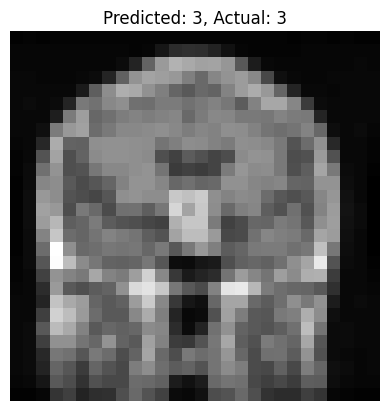

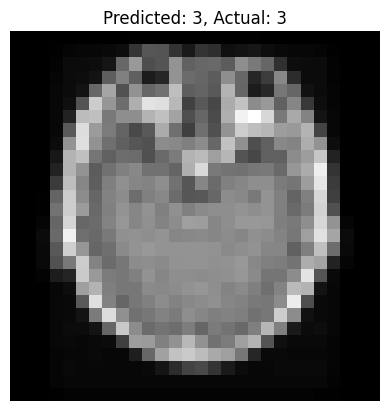

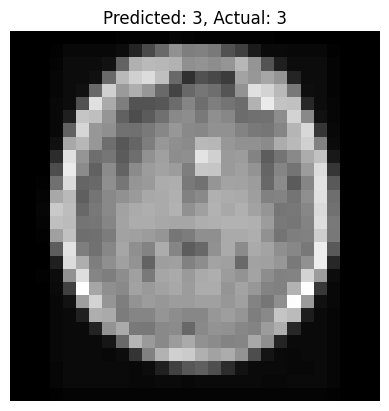

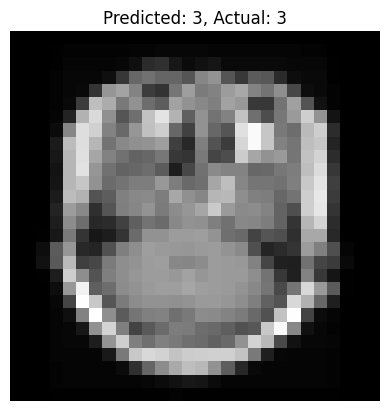

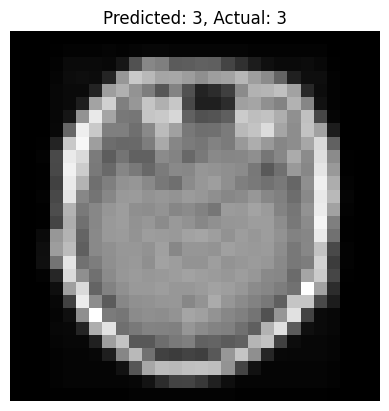

In [ ]:
model_kanc = KANC_MLP(grid_size=5)  # Adjust grid size as needed
criterion = nn.CrossEntropyLoss()  # For classification
optimizer = torch.optim.Adam(model_kanc.parameters(), lr=0.01)  # Adam optimizer
# Move model to GPU if available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_kanc.to(device)
train_model(model_kanc, train_loader, criterion, optimizer, epochs=10)
evaluate_model(model_kanc, test_loader)
classification_report(model_kanc)
evaluate_and_plot(model_kanc, test_loader)

# Architecture - 2
### KKAN (Small) Model with Kolmogorov-Arnold Convolutions and Linear Layer (KKAN)

This implementation defines a small model using Kolmogorov-Arnold Networks (KKAN) for both convolutional and fully connected layers. The architecture consists of two `KAN_Convolutional_Layer` layers, each with 3x3 kernels, followed by max pooling layers for dimensionality reduction. After the convolutional and pooling layers, the output is flattened and passed through a `KANLinear` fully connected layer, which applies Kolmogorov-Arnold operations to the fully connected weights. The final output layer applies `log_softmax` for multi-class classification. The grid size parameter controls the resolution of the KAN operations across both convolutional and linear layers, offering flexibility in feature extraction and representation.


In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim


class KKAN(nn.Module):
    def __init__(self,grid_size: int = 5):
        super().__init__()
        self.conv1 = KAN_Convolutional_Layer(in_channels=1,
            out_channels= 5,
            kernel_size= (3,3),
            grid_size = grid_size
        )

        self.conv2 = KAN_Convolutional_Layer(in_channels=5,
            out_channels= 5,
            kernel_size = (3,3),
            grid_size = grid_size
        )

        self.pool1 = nn.MaxPool2d(
            kernel_size=(2, 2)
        )

        self.flat = nn.Flatten()

        self.linear1 = KANLinear(
            in_features=125,
            out_features = 10,
            grid_size=grid_size

        )
        self.name = f"KKANC (Small) (gs = {grid_size})"


    def forward(self, x):
        x = self.conv1(x)

        x = self.pool1(x)

        x = self.conv2(x)
        x = self.pool1(x)
        x = self.flat(x)
        #print(x.shape)
        x = self.linear1(x)
        x = F.log_softmax(x, dim=1)
        return x

Epoch [1/10], Loss: 0.8026
Epoch [2/10], Loss: 0.5200
Epoch [3/10], Loss: 0.4218
Epoch [4/10], Loss: 0.3503
Epoch [5/10], Loss: 0.3198
Epoch [6/10], Loss: 0.2944
Epoch [7/10], Loss: 0.2653
Epoch [8/10], Loss: 0.2401
Epoch [9/10], Loss: 0.2368
Epoch [10/10], Loss: 0.2199
tensor([0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
tensor([0, 0, 0, 0, 1, 2, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 3, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
tensor([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 3, 0], device='cuda:0')
tensor([0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
tensor([1, 0, 1, 0, 0, 3, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0,

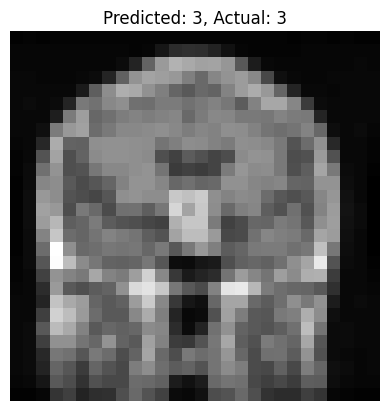

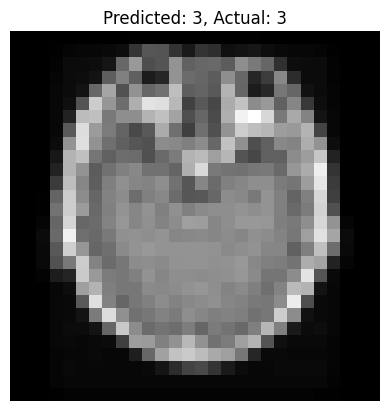

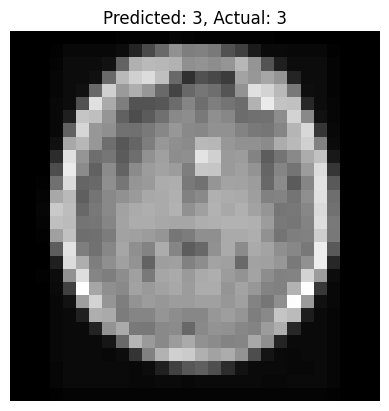

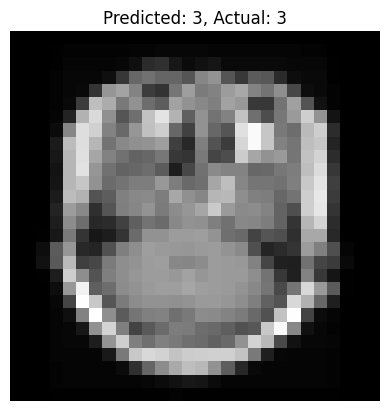

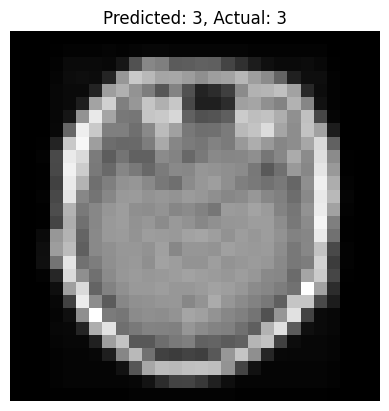

In [ ]:
model_kkan = KKAN(grid_size=5)  # Adjust grid size as needed
criterion = nn.CrossEntropyLoss()  # For classification
optimizer = torch.optim.Adam(model_kkan.parameters(), lr=0.01)  # Adam optimizer
# Move model to GPU if available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_kkan.to(device)
train_model(model_kkan, train_loader, criterion, optimizer, epochs=10)
evaluate_model(model_kkan, test_loader)
classification_report(model_kkan)
evaluate_and_plot(model_kkan, test_loader)

# Architecture - 3
## Conv_KAN (Small) Model with Standard Convolution and Kolmogorov-Arnold Linear Layer

This model combines traditional convolutional layers with a Kolmogorov-Arnold (KAN) linear layer. The architecture starts with two standard 2D convolutional layers, each followed by a max-pooling layer to reduce the spatial dimensions of the input. After the convolutional operations, the feature map is flattened and passed through a fully connected `KANLinear` layer, which applies Kolmogorov-Arnold network operations. The final layer uses `log_softmax` for classification into 10 classes. The `grid_size` parameter affects the resolution of the KAN operations applied to the fully connected layer, providing flexibility for feature extraction.


In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim


class Conv_KAN(nn.Module):
    def __init__(self,grid_size: int = 5):
        super().__init__()
        self.conv1 = nn.Conv2d(
            1, 5, 3
        )

        self.conv2 = nn.Conv2d(
            5, 5, 3
        )

        self.pool1 = nn.MaxPool2d(
            kernel_size=(2, 2)
        )

        self.flat = nn.Flatten()

        self.linear1 = KANLinear(
            in_features=125,
            out_features = 10,
            grid_size=grid_size

        )
        self.name = f"Conv_KAN (Small) (gs = {grid_size})"


    def forward(self, x):
        x = self.conv1(x)

        x = self.pool1(x)

        x = self.conv2(x)
        x = self.pool1(x)
        x = self.flat(x)
        #print(x.shape)
        x = self.linear1(x)
        x = F.log_softmax(x, dim=1)
        return x

Epoch [1/10], Loss: 0.8366
Epoch [2/10], Loss: 0.5296
Epoch [3/10], Loss: 0.4220
Epoch [4/10], Loss: 0.3861
Epoch [5/10], Loss: 0.3524
Epoch [6/10], Loss: 0.3009
Epoch [7/10], Loss: 0.2814
Epoch [8/10], Loss: 0.2632
Epoch [9/10], Loss: 0.2404
Epoch [10/10], Loss: 0.2503
tensor([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 3, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
tensor([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0,
        0, 1, 0, 1, 0, 0, 0, 0], device='cuda:0')
tensor([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
        0, 1, 0, 1, 0, 0, 0, 0], device='cuda:0')
tensor([0, 0, 0, 1, 0, 1, 2, 2, 2, 2, 0, 0, 0, 1, 3, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
tensor([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
tensor([0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 2, 0, 0, 0, 0, 0,

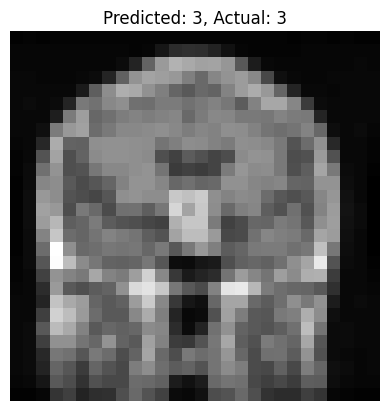

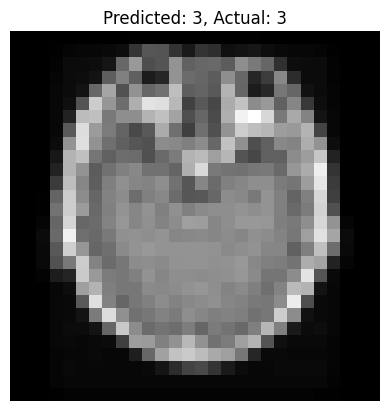

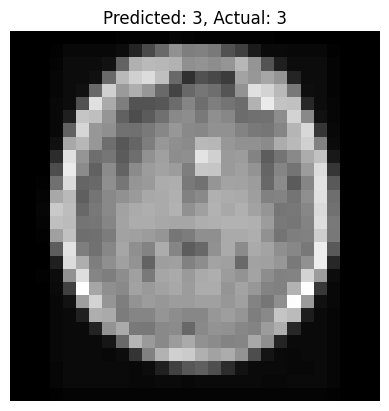

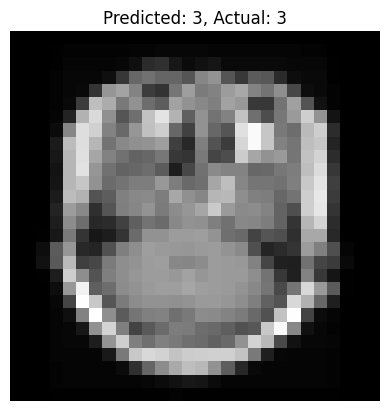

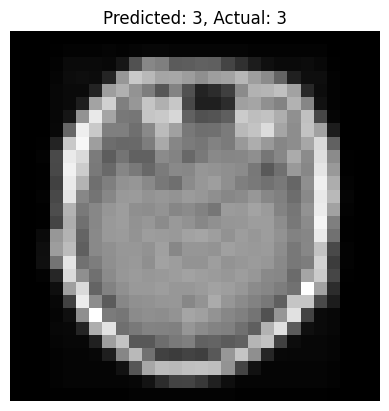

In [ ]:
model_conv_kan = Conv_KAN(grid_size=5)  # Adjust grid size as needed
criterion = nn.CrossEntropyLoss()  # For classification
optimizer = torch.optim.Adam(model_conv_kan.parameters(), lr=0.01)  # Adam optimizer
# Move model to GPU if available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_conv_kan.to(device)
train_model(model_conv_kan, train_loader, criterion, optimizer, epochs=10)
evaluate_model(model_conv_kan, test_loader)
classification_report(model_conv_kan)
evaluate_and_plot(model_conv_kan, test_loader)

# Architecture - 4
### KKAN (Medium) Model with Kolmogorov-Arnold Convolutions and Linear Layer (KKAN)

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim


class KKAN(nn.Module):
    def __init__(self,grid_size: int = 5):
        super().__init__()
        self.conv1 = KAN_Convolutional_Layer(in_channels=1,
            out_channels= 5,
            kernel_size= (3,3),
            grid_size = grid_size
        )

        self.conv2 = KAN_Convolutional_Layer(in_channels=5,
            out_channels= 10,
            kernel_size = (3,3),
            grid_size = grid_size
        )

        self.pool1 = nn.MaxPool2d(
            kernel_size=(2, 2)
        )

        self.flat = nn.Flatten()

        self.linear1 = KANLinear(
            in_features=250,
            out_features = 10,
            grid_size=grid_size

        )
        self.name = f"KKANC (Medium) (gs = {grid_size})"


    def forward(self, x):
        x = self.conv1(x)

        x = self.pool1(x)

        x = self.conv2(x)
        x = self.pool1(x)
        x = self.flat(x)
        #print(x.shape)
        x = self.linear1(x)
        x = F.log_softmax(x, dim=1)
        return x

Epoch [1/10], Loss: 0.7994
Epoch [2/10], Loss: 0.4680
Epoch [3/10], Loss: 0.3677
Epoch [4/10], Loss: 0.3068
Epoch [5/10], Loss: 0.2652
Epoch [6/10], Loss: 0.2409
Epoch [7/10], Loss: 0.2248
Epoch [8/10], Loss: 0.2078
Epoch [9/10], Loss: 0.1662
Epoch [10/10], Loss: 0.1458
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 3, 0, 0, 0, 1, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 1, 1, 0], device='cuda:0')
tensor([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 3, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,

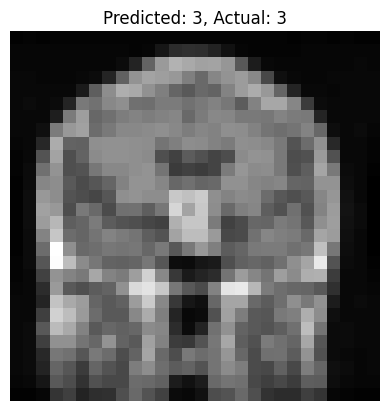

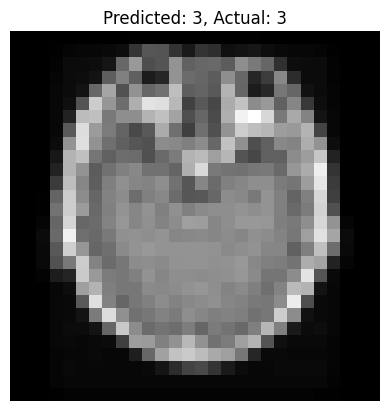

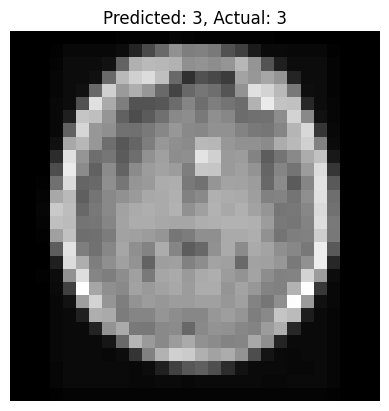

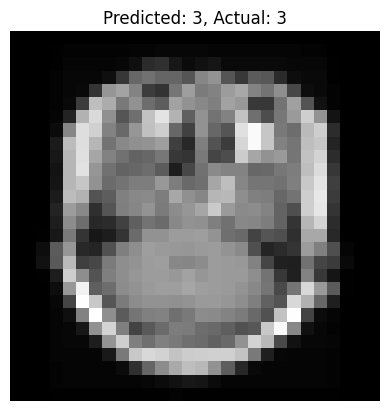

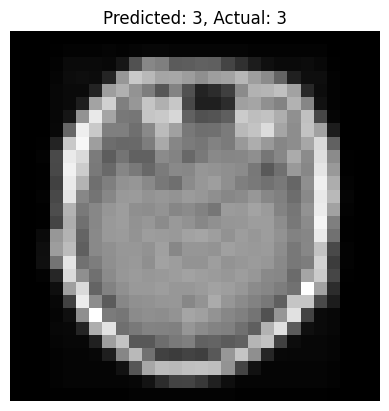

In [ ]:
model_kkan_medium = KKAN(grid_size=5)  # Adjust grid size as needed
criterion = nn.CrossEntropyLoss()  # For classification
optimizer = torch.optim.Adam(model_kkan_medium.parameters(), lr=0.01)  # Adam optimizer
# Move model to GPU if available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_kkan_medium.to(device)
train_model(model_kkan_medium, train_loader, criterion, optimizer, epochs=10)
evaluate_model(model_kkan_medium, test_loader)
classification_report(model_kkan_medium)
evaluate_and_plot(model_kkan_medium, test_loader)

# Architecture - 5
## KANC MLP (Medium) Model with Kolmogorov-Arnold Convolutional Layers (KAN)

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim


class KANC_MLP(nn.Module):
    def __init__(self,grid_size: int = 5):
        super().__init__()
        self.conv1 = KAN_Convolutional_Layer(in_channels=1,
            out_channels= 5,
            kernel_size= (3,3),
            grid_size = grid_size
        )

        self.conv2 = KAN_Convolutional_Layer(in_channels=5,
            out_channels= 10,
            kernel_size = (3,3),
            grid_size = grid_size
        )

        self.pool1 = nn.MaxPool2d(
            kernel_size=(2, 2)
        )

        self.flat = nn.Flatten()

        self.linear1 = nn.Linear(250, 10)
        self.name = f"KANC MLP (Medium) (gs = {grid_size})"


    def forward(self, x):
        x = self.conv1(x)

        x = self.pool1(x)

        x = self.conv2(x)
        x = self.pool1(x)
        x = self.flat(x)
        #print(x.shape)
        x = self.linear1(x)
        x = F.log_softmax(x, dim=1)
        return x

Epoch [1/10], Loss: 0.8229
Epoch [2/10], Loss: 0.5384
Epoch [3/10], Loss: 0.4627
Epoch [4/10], Loss: 0.3855
Epoch [5/10], Loss: 0.3306
Epoch [6/10], Loss: 0.2962
Epoch [7/10], Loss: 0.2711
Epoch [8/10], Loss: 0.2444
Epoch [9/10], Loss: 0.2210
Epoch [10/10], Loss: 0.2253
tensor([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
tensor([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 1, 0, 0, 0, 0], device='cuda:0')
tensor([0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 1], device='cuda:0')
tensor([1, 0, 0, 0, 3, 3, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

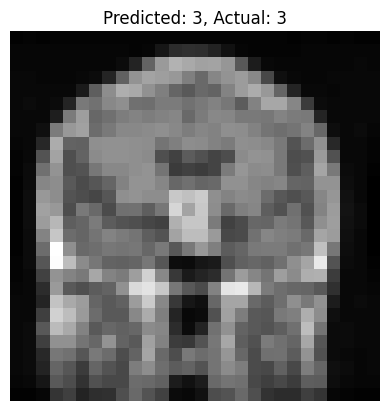

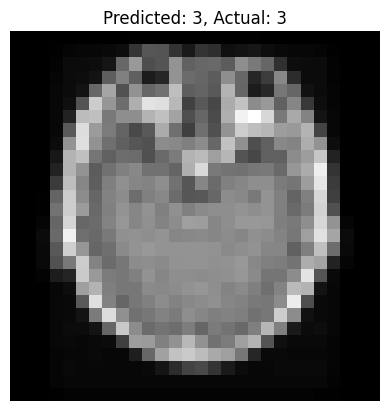

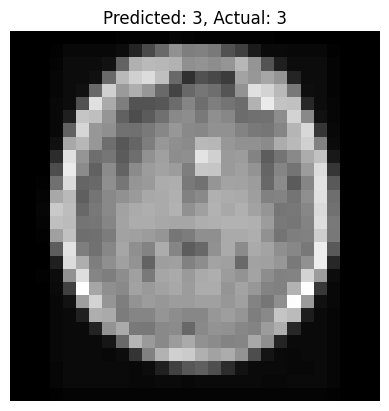

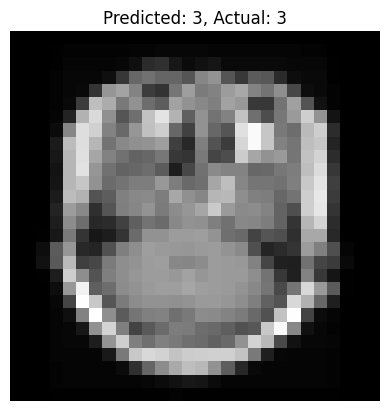

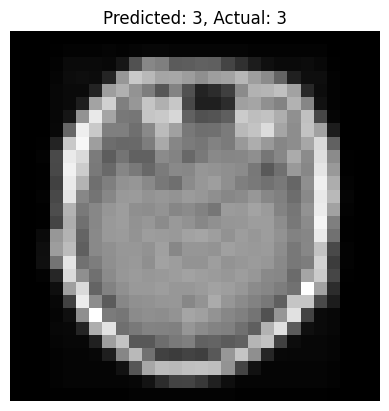

In [ ]:
model_kanc_medium = KANC_MLP(grid_size=5)  # Adjust grid size as needed
criterion = nn.CrossEntropyLoss()  # For classification
optimizer = torch.optim.Adam(model_kanc_medium.parameters(), lr=0.01)  # Adam optimizer
# Move model to GPU if available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_kanc_medium.to(device)
train_model(model_kanc_medium, train_loader, criterion, optimizer, epochs=10)
evaluate_model(model_kanc_medium, test_loader)
classification_report(model_kanc_medium)
evaluate_and_plot(model_kanc_medium, test_loader)


# Architecture - 6
## Conv_KAN (Medium) Model with Standard Convolution and Kolmogorov-Arnold Linear Layer

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim


class Conv_KAN(nn.Module):
    def __init__(self,grid_size: int = 5):
        super().__init__()
        self.conv1 = nn.Conv2d(
            1, 5, 3
        )

        self.conv2 = nn.Conv2d(
            5, 10, 3
        )

        self.pool1 = nn.MaxPool2d(
            kernel_size=(2, 2)
        )

        self.flat = nn.Flatten()

        self.linear1 = KANLinear(
            in_features=250,
            out_features = 10,
            grid_size=grid_size

        )
        self.name = f"Conv_KAN (Medium) (gs = {grid_size})"


    def forward(self, x):
        x = self.conv1(x)

        x = self.pool1(x)

        x = self.conv2(x)
        x = self.pool1(x)
        x = self.flat(x)
        #print(x.shape)
        x = self.linear1(x)
        x = F.log_softmax(x, dim=1)
        return x

Epoch [1/10], Loss: 0.8328
Epoch [2/10], Loss: 0.4836
Epoch [3/10], Loss: 0.3691
Epoch [4/10], Loss: 0.3221
Epoch [5/10], Loss: 0.2743
Epoch [6/10], Loss: 0.2339
Epoch [7/10], Loss: 0.1974
Epoch [8/10], Loss: 0.1930
Epoch [9/10], Loss: 0.1735
Epoch [10/10], Loss: 0.1675
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
tensor([0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 3, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,

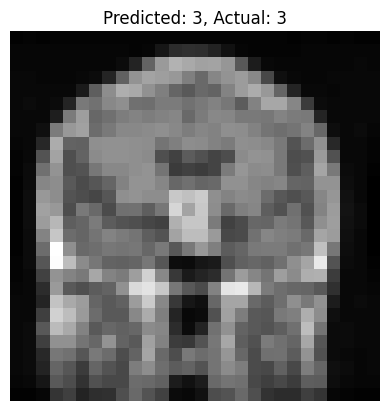

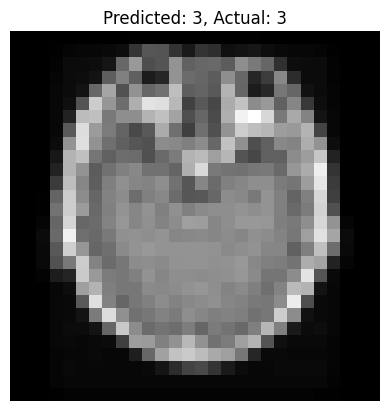

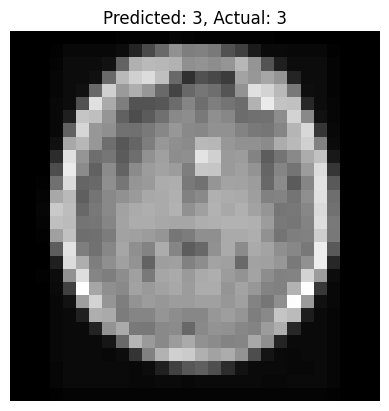

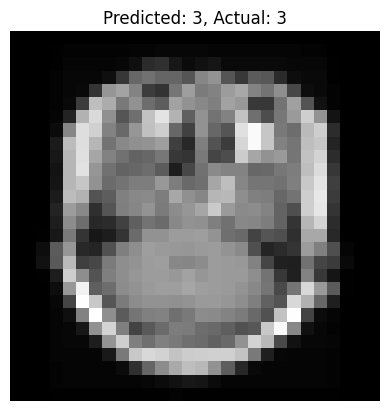

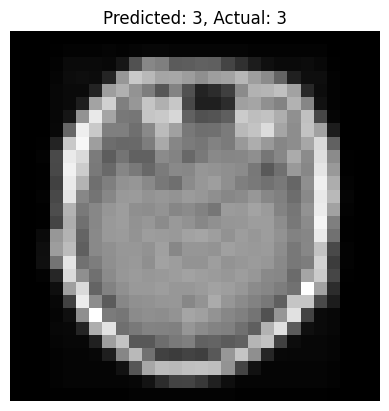

In [ ]:
model_conv_kan_medium = Conv_KAN(grid_size=5)  # Adjust grid size as needed
criterion = nn.CrossEntropyLoss()  # For classification
optimizer = torch.optim.Adam(model_conv_kan_medium.parameters(), lr=0.01)  # Adam optimizer
# Move model to GPU if available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_conv_kan_medium.to(device)
train_model(model_conv_kan_medium, train_loader, criterion, optimizer, epochs=10)
evaluate_model(model_conv_kan_medium, test_loader)
classification_report(model_conv_kan_medium)
evaluate_and_plot(model_conv_kan_medium, test_loader)

# Architecture - 7
## KANC MLP (Big)

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim


class KANC_MLP(nn.Module):
    def __init__(self,grid_size: int = 5):
        super().__init__()
        self.conv1 = KAN_Convolutional_Layer(in_channels=1,
            out_channels= 5,
            kernel_size= (3,3),
            grid_size = grid_size
        )

        self.conv2 = KAN_Convolutional_Layer(in_channels=5,
            out_channels= 10,
            kernel_size = (3,3),
            grid_size = grid_size
        )

        self.pool1 = nn.MaxPool2d(
            kernel_size=(2, 2)
        )

        self.flat = nn.Flatten()

        self.linear1 = nn.Linear(250, 100)
        self.linear2 = nn.Linear(100, 10)
        self.name = f"KANC MLP (Big) (gs = {grid_size})"


    def forward(self, x):
        x = self.conv1(x)

        x = self.pool1(x)

        x = self.conv2(x)
        x = self.pool1(x)
        x = self.flat(x)
        #print(x.shape)
        x = self.linear1(x)
        x = self.linear2(x)
        x = F.log_softmax(x, dim=1)
        return x

Epoch [1/10], Loss: 0.8028
Epoch [2/10], Loss: 0.5387
Epoch [3/10], Loss: 0.4429
Epoch [4/10], Loss: 0.3953
Epoch [5/10], Loss: 0.3761
Epoch [6/10], Loss: 0.3305
Epoch [7/10], Loss: 0.3024
Epoch [8/10], Loss: 0.2904
Epoch [9/10], Loss: 0.2899
Epoch [10/10], Loss: 0.2697
tensor([1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 3, 0, 0, 0, 1, 3, 0, 0, 0,
        1, 0, 0, 0, 0, 1, 1, 0], device='cuda:0')
tensor([0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0,
        0, 1, 0, 1, 0, 0, 0, 0], device='cuda:0')
tensor([0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0,
        0, 1, 0, 1, 1, 0, 1, 0], device='cuda:0')
tensor([0, 0, 0, 1, 0, 1, 2, 2, 0, 0, 0, 1, 0, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 1, 0, 0, 1, 1, 0], device='cuda:0')
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
tensor([1, 0, 1, 0, 0, 3, 0, 0, 0, 0, 3, 0, 0, 0, 1, 0, 3, 1, 1, 0, 0, 0, 0, 0,

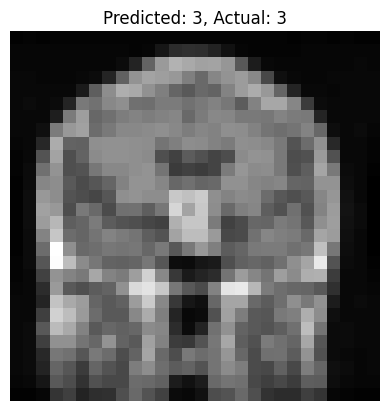

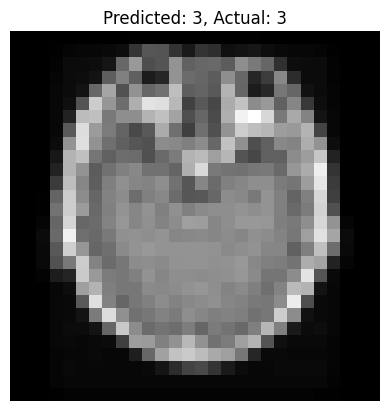

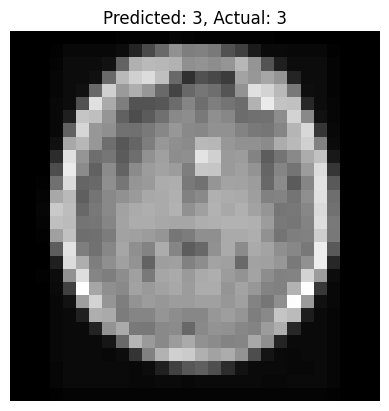

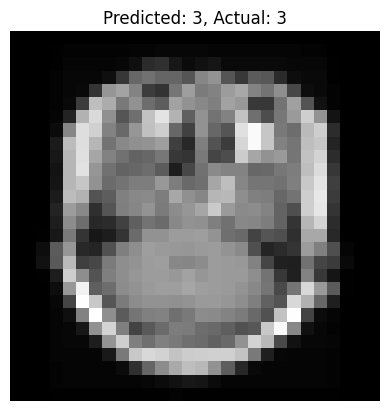

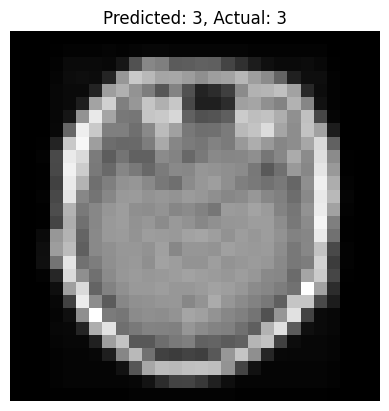

In [ ]:
model_kanc_big = KANC_MLP(grid_size=5)  # Adjust grid size as needed
criterion = nn.CrossEntropyLoss()  # For classification
optimizer = torch.optim.Adam(model_kanc_big.parameters(), lr=0.01)  # Adam optimizer
# Move model to GPU if available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_kanc_big.to(device)
train_model(model_kanc_big, train_loader, criterion, optimizer, epochs=10)
evaluate_model(model_kanc_big, test_loader)
classification_report(model_kanc_big)
evaluate_and_plot(model_kanc_big, test_loader)